# Data Preparation
In this notebook all data preparation steps will be taken with the end goal to produce a clean and ready to use dataset

First step is to load the libraries and set global variables

In [80]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

SEED=42

Now the data can be loaded. The labels will be stored initially in the dataframe and the paths to images will be added later. The seperator used in the csv is a tab

In [81]:
image_dir = '../data/toy_dataset/'
labels_path = '../data/toy_dataset_label.csv'

df = pd.read_csv(labels_path, sep='\t')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43455 entries, 0 to 43454
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         43455 non-null  int64 
 1   FILE       43454 non-null  object
 2   AUTHOR     43455 non-null  object
 3   BORN-DIED  43455 non-null  object
 4   TITLE      43455 non-null  object
 5   DATE       43455 non-null  object
 6   TECHNIQUE  43455 non-null  object
 7   LOCATION   43455 non-null  object
 8   FORM       43455 non-null  object
 9   TYPE       43455 non-null  object
 10  SCHOOL     43455 non-null  object
 11  TIMELINE   43455 non-null  object
 12  URL        43455 non-null  object
dtypes: int64(1), object(12)
memory usage: 4.3+ MB


In [82]:
df.sample(n=3)

,ID,FILE,AUTHOR,BORN-DIED,TITLE,DATE,TECHNIQUE,LOCATION,FORM,TYPE,SCHOOL,TIMELINE,URL
10675,10676,10676.jpg,"DEGAS, Edgar","(b. 1834, Paris, d. 1917, Paris)",Racehorses in Longchamps,c. 1874,"Oil on canvas, 34 x 42 cm","Museum of Fine Arts, Boston",painting,other,French,1851-1900,http://www.wga.hu/html/d/degas/2/1870s_18.html
41799,41800,41800.jpg,"VERVLOET, Frans","(b. 1795, Mechelen, d. 1872, Venezia)",View of the Palazzo Ducale and the Riva degli ...,1830,"Oil on canvas, 30 x 42 cm",Private collection,painting,landscape,Belgian,1801-1850,http://www.wga.hu/html/v/vervloet/venice2.html
24953,24954,24954.jpg,"MEISSONNIER, Juste-Aurèle","(b. 1698, Torino, d. 1750, Paris)",Design of a Couch for Count Bilenski,1735,"Pen, brush, Indian ink and watercolour, 233 x ...","The Hermitage, St. Petersburg",graphics,study,French,1701-1750,http://www.wga.hu/html/m/meissonn/design1.html


The labels are loaded succesfully.

## Select Data

### Columns
The columns that need to be included are:
- ID
- FORM (Only for filtering)
- TYPE
- FILE

With these columns a good first modeling phase can be started too see technical viability

In [83]:
# From the .info() it was visible that FILE has one NaN value
df = df.dropna(subset=['FILE'])

# Create a dataframe with only the relevant columns
columns_to_keep = ['ID', 'FORM', 'TYPE', 'FILE']
df = df[columns_to_keep]

df.info()
df.sample(n=3)

<class 'pandas.core.frame.DataFrame'>
Index: 43454 entries, 0 to 43453
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      43454 non-null  int64 
 1   FORM    43454 non-null  object
 2   TYPE    43454 non-null  object
 3   FILE    43454 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.7+ MB


,ID,FORM,TYPE,FILE
11538,11539,painting,portrait,11539.jpg
8687,8688,sculpture,mythological,8688.jpg
35034,35035,architecture,other,35035.jpg


### Rows
- Rows where the `FORM` equals `painting` will be kept
- The `TYPE` rows will be filtered to only include `religious`, `portrait`, `landscape`, and `mythological`

In [84]:
# Before this operation the values have to be normalized 
df['FORM'] = df['FORM'].astype(str).str.strip().str.lower()
df['TYPE'] = df['TYPE'].astype(str).str.strip().str.lower()

types_to_keep = ['religious', 'portrait', 'landscape', 'mythological']
df = df[df['TYPE'].isin(types_to_keep)]

df = df[
    (df['FORM'] == 'painting') &
    (df['TYPE'].isin(types_to_keep))
]

df.info()
df.sample(n=3)

<class 'pandas.core.frame.DataFrame'>
Index: 23697 entries, 0 to 43446
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      23697 non-null  int64 
 1   FORM    23697 non-null  object
 2   TYPE    23697 non-null  object
 3   FILE    23697 non-null  object
dtypes: int64(1), object(3)
memory usage: 925.7+ KB


,ID,FORM,TYPE,FILE
9759,9760,painting,mythological,9760.jpg
19557,19558,painting,mythological,19558.jpg
8643,8644,painting,portrait,8644.jpg


Now that the filter is applied the FORM column can be dropped. This holds no extra information for the model to use as it is only one repeated value

In [85]:
df = df.drop('FORM', axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23697 entries, 0 to 43446
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      23697 non-null  int64 
 1   TYPE    23697 non-null  object
 2   FILE    23697 non-null  object
dtypes: int64(1), object(2)
memory usage: 740.5+ KB


The amount of rows (`23697`) is too high to get initial insights, it is also not evenly distributed as seen in the EDA

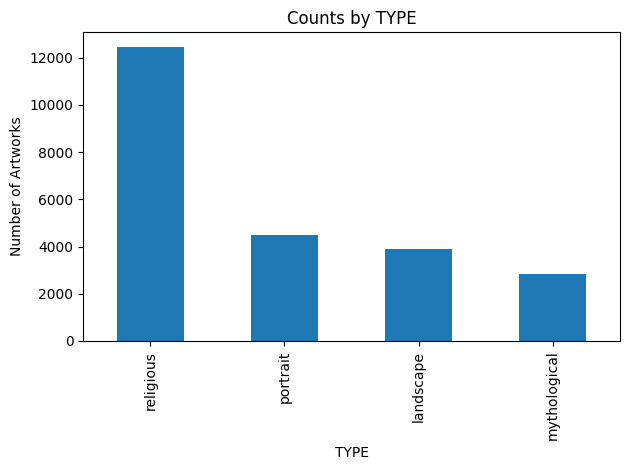

In [86]:
plt.figure()
df['TYPE'].value_counts().plot.bar()
plt.title('Counts by TYPE')
plt.ylabel('Number of Artworks')
plt.tight_layout()

For every type there should be `200` rows for a good initial insight into model performance and make model training feasible.

In [87]:
n_samples = 200

# 200 random samples from each TYPE
df = df.groupby('TYPE', group_keys=False).apply(lambda x: x.sample(n=n_samples, random_state=SEED))

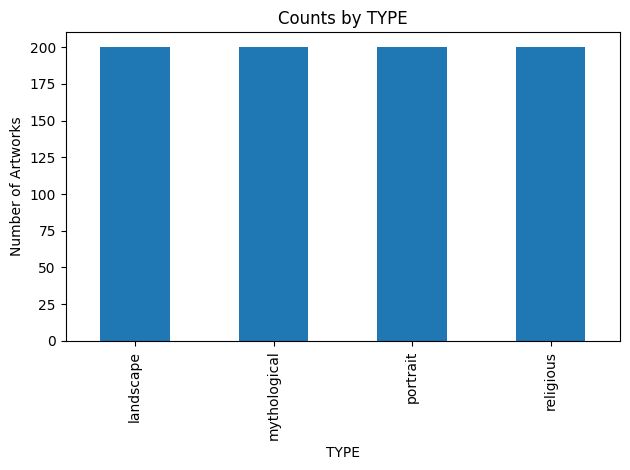

In [88]:
plt.figure()
df['TYPE'].value_counts().plot.bar()
plt.title('Counts by TYPE')
plt.ylabel('Number of Artworks')
plt.tight_layout()

Now the relevant data has been selected the index will be reset

In [89]:
df = df.reset_index(drop=True)
df.sample(n=5, random_state=SEED)

,ID,TYPE,FILE
696,14924,religious,14924.jpg
667,37376,religious,37376.jpg
63,5971,landscape,5971.jpg
533,36991,portrait,36991.jpg
66,7873,landscape,7873.jpg


## Clean Data
All columns will be transformed to lowercase. Checks will be implemented that throw an error if any value is not lowercase or includes any unwanted spaces

In [90]:
df.columns = [col.lower() for col in df.columns]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      800 non-null    int64 
 1   type    800 non-null    object
 2   file    800 non-null    object
dtypes: int64(1), object(2)
memory usage: 18.9+ KB


In [91]:
def check_df_string_cleanliness(df):
    # Check all string/object columns
    for col in df.select_dtypes(include=['object', 'string']):
        col_notnull = df[col].dropna()
        # Check for lowercase
        if not col_notnull.apply(lambda x: x == x.lower()).all():
            raise ValueError(f"Column '{col}' contains non-lowercase string values.")
        # Check for leading/trailing whitespace
        if not col_notnull.apply(lambda x: x == x.strip()).all():
            raise ValueError(f"Column '{col}' contains leading or trailing whitespace.")
    print("All string values are lowercase and have no leading/trailing whitespace")

check_df_string_cleanliness(df)

All string values are lowercase and have no leading/trailing whitespace


All column names and values within the rows are now lowercase and without spaces. 

The last step is to change the DType for `form` and `type` to categorical

In [92]:
categorical_cols = ['type']

for col in categorical_cols:
    df[col] = df[col].astype('category')
    print(f"Number of unique values for column {col}: {df[col].nunique()}")

df.info()

Number of unique values for column type: 4
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   id      800 non-null    int64   
 1   type    800 non-null    category
 2   file    800 non-null    object  
dtypes: category(1), int64(1), object(1)
memory usage: 13.6+ KB


## Construct Data

From the `file` column an `image_path` column can be created to load the images at the moment they are needed from the central storage

In [93]:
df['image_path'] = df['file'].apply(lambda x: os.path.join(image_dir, x))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   id          800 non-null    int64   
 1   type        800 non-null    category
 2   file        800 non-null    object  
 3   image_path  800 non-null    object  
dtypes: category(1), int64(1), object(2)
memory usage: 19.9+ KB


The file column will be dropped as to not have duplicate information

In [94]:
df = df.drop('file', axis=1)

In [95]:
def check_df_image_path(df, image_path_col):
# Check if image paths exist and are valid
    if image_path_col in df.columns:
        missing_paths = df[~df[image_path_col].dropna().apply(os.path.exists)]
        if not missing_paths.empty:
            raise ValueError(
                f"Some paths in '{image_path_col}' do not exist. Example(s):\n{missing_paths[image_path_col].head()}"
            )
        print(f"All paths in '{image_path_col}' exist and are correctly formatted.")
    else:
        print(f"Column '{image_path_col}' not found in DataFrame.")


check_df_image_path(df=df, image_path_col='image_path')

All paths in 'image_path' exist and are correctly formatted.


From the EDA it is known that 2 rows did not have an image available. With the above check it is confirmed that those images are not part of this subset.

## Integrate Data

During this iteration there is no;
- merging or external tables
- no aggregating or grouping
- no joins

## Format Data

Here the dataset is finalized for modeling by performing the following:

- One-hot encoding of categorical variables (`type`) for compatibility with machine learning models
- Shuffling the dataframe to avoid ordering bias during training and validation splits
- Documenting image resizing to ensure compatibility with CNN models

In [100]:
# one hot encoding
df_encoded = pd.get_dummies(df, columns=['type'])

# Shuffle
df_encoded = df_encoded.sample(frac=1, random_state=SEED).reset_index(drop=True)

df_encoded.sample(n=3, random_state=SEED)

,id,image_path,type_landscape,type_mythological,type_portrait,type_religious
696,36504,../data/toy_dataset/36504.jpg,True,False,False,False
667,13794,../data/toy_dataset/13794.jpg,False,True,False,False
63,42302,../data/toy_dataset/42302.jpg,False,True,False,False


**Image REsizing**

For compatibility with CNNs all images must be standardized to a fixed size. This is currently not the case as seen in the EDA

To maximize flexibility and avoid unnecessary disk usage images will be resized on the fly during model training and inference. No image files will be modified or overwritten during the data preparation

The image resizing function will be defined and applied as part of the pipeline in the modeling phase

# Saving the dataframe

In [ ]:
output_dir = "../data/processed/"
os.makedirs(output_dir, exist_ok=True)

pkl_path = os.path.join(output_dir, "prepared_art500k_subset_paintings.pkl")
df_encoded.to_pickle(pkl_path)

print(f"DataFrame successfully saved to {pkl_path}")

DataFrame successfully saved to ../data/processed/prepared_art500k_subset_paintings.pkl
